# Data Preprocessing for Pointer Network
In this notebook we are showing how we do data preprocessing in order to feed the CNN stories dataset to our pointer network.

In [16]:
import pandas as pd
import numpy as np
import json
import glob
%%matplotlib inline

UsageError: Line magic function `%%matplotlib` not found.


In [17]:
def mmap(fn, elem):
    return list(map(fn, elem))

def getel(n, lst): 
    return mmap(lambda x: x[n], lst)

## Dataset Cleaning
The cleaning of the CNN dataset which we use is kindly taken from machinelearningmaster.com

You can find the whole article here:
https://machinelearningmastery.com/prepare-news-articles-text-summarization/?unapproved=487774&moderation-hash=c397686a5fc42785c709030b2bcf4ebc#comment-487774

In [ ]:
from os import listdir
import string

# load doc into memory


def load_doc(filename):
    # open the file as read only
    file = open(filename, encoding='utf-8')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# split a document into news story and highlights


def split_story(doc):
    # find first highlight
    index = doc.find('@highlight')
    # split into story and highlights
    story, highlights = doc[:index], doc[index:].split('@highlight')
    # strip extra white space around each highlight
    highlights = [h.strip() for h in highlights if len(h) > 0]
    return story, highlights

# load all stories in a directory


def load_stories(directory):
    stories = list()
    for name in listdir(directory):
        filename = directory + '/' + name
        # load document
        doc = load_doc(filename)
        # split into story and highlights
        story, highlights = split_story(doc)
        # store
        stories.append({'story': story, 'highlights': highlights})
    return stories

# clean a list of lines


def clean_lines(lines):
    cleaned = list()
    # prepare a translation table to remove punctuation
    table = str.maketrans('', '', string.punctuation)
    for line in lines:
        # strip source cnn office if it exists
        index = line.find('(CNN) -- ')
        if index > -1:
            line = line[index+len('(CNN)'):]
        # tokenize on white space
        line = line.split()
        # convert to lower case
        line = [word.lower() for word in line]
        # remove punctuation from each token
        line = [w.translate(table) for w in line]
        # remove tokens with numbers in them
        line = [word for word in line if word.isalpha()]
        # store as string
        cleaned.append(' '.join(line))
    # remove empty strings
    cleaned = [c for c in cleaned if len(c) > 0]
    return cleaned


# load stories
directory = './cnn_dataset/cnn/stories/'
stories = load_stories(directory)
print('Loaded Stories %d' % len(stories))

# clean stories
for example in stories:
    example['story'] = clean_lines(example['story'].split('\n'))
    example['highlights'] = clean_lines(example['highlights'])




In [ ]:
stories[0]['highlights']

In [30]:
# save to file
from pickle import dump, load
dump(stories, open('cnn_dataset.pkl', 'wb'))

In [18]:
# load from file
from pickle import dump, load
stories = load(open('cnn_dataset.pkl', 'rb'))
print('Loaded Stories %d' % len(stories))

Loaded Stories 92579


## Data sampling
After the dataset is cleaned and tokenized, we can select a sample of the dataset to work with and we can start doing our analysis of the dataset. Here we choose a 10% which account for 9258 examples

After the dataset is cleaned and tokenized, we can select a sample of the dataset to work with and we can start doing our analysis of the dataset

In [19]:
size = len(stories) // 10
# Set Seed
np.random.seed(seed=13367)
stories = np.array(stories)
indexes = np.random.choice(list(range(stories.shape[0])), size=size, replace=False)

# Sample 10% of dataset
random_sample = stories[indexes]

In [20]:
size = len(stories) // 10
# Set Seed
np.random.seed(seed=13367)
stories = np.array(stories)
indexes = np.random.choice(list(range(92579)), size=size, replace=False)

# Sample 10% of dataset
random_sample = stories[indexes]

We also select the first 10 sentences in order to reduce the training size for saving computational times. This is important because there may be outliers in terms of sentence length that will increase the size of the training set because of the padding inserted in the other sentences. 

In [21]:
def get_first_n_sentence(data, n):
    tmp = data.tolist()
    X = [". ".join(obj['story'][:n]) for obj in tmp]
    y = [". ".join(obj['highlights']) for obj in tmp]
    return X, y

In [22]:
X, y = get_first_n_sentence(random_sample, 10)

We now print respectively the max sentence length and the mean length, in order to see how much more we can save in memory. It seems that the max length here is 1k of words against the 301 of the mean. So we still have outliers to remove from this dataset

In [23]:
# See max and mean length of sentences
print('Max sentence length is', np.amax(list(map(lambda x: len(x.split(' ')), X))))
print('Mean sentence length is', np.mean(list(map(lambda x: len(x.split(' ')), X))))

Max sentence length is 1206
Mean sentence length is 301.8644269201685


We now want to select a nice cutting point that retains the majority of the dataset without increasing much computational time. Hence we plot the sizes of all the examples and try to understand at first what would be a nice threshold. Looking at the graph a max length of 500 words seems to be a nice solution, but lets get a more accurate visualization

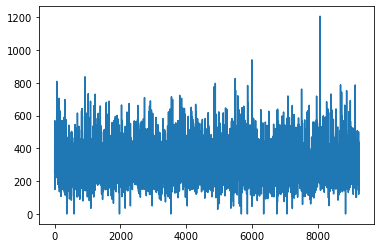

In [24]:
import matplotlib.pyplot as plt

# Distribution of words in the dataset, we cannot understand a lot, but it seems ~500 or 600 a nice cutting point
# for selecting a max_word_length
plt.plot(range(len(X)), list(map(lambda x: len(x.split(' ')), X)))

Now we plot the sentence length against the cumulative sum of the longer sentences. We finally choose 500 as the max length of the sentence we want to allow in our dataset. We choose to discard the sentence instead of pruning it because cutting a sentence midway usually add more noise

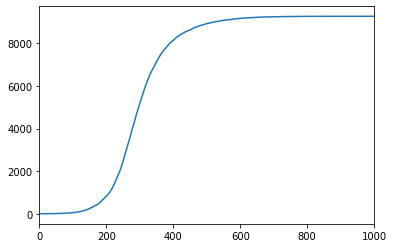

In [25]:
XX = list(map(lambda x: x.split(' '), X))
def ds_size(n):
    return np.sum(list(map(lambda x: 1 if len(x) < n else 0, XX)))

# plot the dataset size to get a nice cutting point, we confirm 500 max_len for this dataset
plt.xlim(0, 1000)
plt.plot(range(len(X)), [ds_size(n) for n in range(len(X))])

In [26]:
indexes = mmap(lambda x:len(x.split(' ')) < 500, X)

In [27]:
X = np.array(X)[indexes]
y = np.array(y)[indexes]

In [28]:
print(len(X) == len(y), len(X))

True 8911


## Tokenization and Vocabulary Building
We now tokenize our words with TreebankWordTokenizer and select the size of the vocabulary to include less words as possible paying attention not generating too many unknowns in the dataset. We plot the most frequent words and discover as excpected a Zipf distribution where the most common words are very few respect all the others. Then we select a threshold to include only the words that maximizes our tradeoff of voc_size vs recall of words found in the training set.

In [29]:
# tokenize with TreebankWord tokenizer
from nltk.tokenize import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()

X_tokens = [tokenizer.tokenize(x) for x in X]
y_tokens = [tokenizer.tokenize(x) for x in y]

In [30]:
from collections import Counter

In [31]:
def flatmap(lst):
    return [word for sent in lst for word in sent]

voc_counts = Counter(flatmap(X_tokens) + flatmap(y_tokens))

Here we select the firs

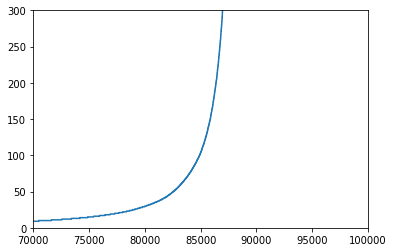

In [32]:
# get only the most frequent words. It follows a zipf distribution as expected
# we need to choose a proper threshold, 
py = mmap(lambda x: x[1], voc_counts.most_common())[::-1]
px = range(0, len(py))
plt.xlim(70000, 100000)
plt.ylim(0, 300)
plt.plot(px, py)

In [33]:
# a vocabulary of 13k words seems fine for this task, we probably can compress more
# for saving memory and computation time but let's test this choice first
print('The final vocabulary size is', len(py) - 75000, 'against the unfiltered', len(py))

The final vocabulary size is 13128 against the unfiltered 88128


In [34]:
# make the cut
voc = voc_counts.most_common()[:13128]

We now generate the vocabulary and the inverse vocabulary, and we also need to adapt our dataset to be the input of our neural network. As the input follows a seq2seq model we need to remember to define special symbols which are the START and the END tokens.

In [35]:
# BUILD THE VOCABULARY

words = getel(0, voc)
w2id = dict(zip(words, range(len(words))))

# add <start>, <end>, <unk> token to vocabulary
w2id['<start>'] = len(w2id.keys())
w2id['<end>'] = len(w2id.keys())
w2id['<unk>'] = len(w2id.keys())
w2id['<pad>'] = len(w2id.keys())

# BUILD THE REVERSE VOCABULARY

id2w = dict(mmap(lambda x: (x[1], x[0]), w2id.items()))

In [36]:
# CONVERT X TOKENS TO INDEXES

X_id = [[w2id.get(word, w2id['<unk>']) for word in sent] for sent in X_tokens]

# ADD START AND END TOKEN AND CONVERT Y TO ID
y_id = [[w2id['<start>']] + \
        [w2id.get(word, w2id['<unk>']) for word in sent] + \
        [w2id['<end>']] for sent in y_tokens]

In [37]:
# SEQUENCE PADDING

from keras.preprocessing.sequence import pad_sequences
X_id=pad_sequences(X_id, value=w2id['<pad>'], padding='post')
y_id = pad_sequences(y_id, value=w2id['<pad>'], padding='post')

Using TensorFlow backend.


## Adapting the dataset to the network
We need to generated 3 input for our network:
* The X input which holds or the articles, composed by padded sequences of indexes
* The Y input which holds indexes for the summaries, format is like the X
* The G input, with the same shape of Y, holds the information about if the index in the same position as Y will be generated by the network, or selected from the input

In [38]:
%%time
y_id_new = []
pad_index = w2id['<pad>']
def p_gen_index(elem, inp, i, log=False, padding=pad_index):
    if i % 1000 == 0 and log:
        print('starting example n°', i)
    if elem == padding:
        y_id_new.append(padding)
        return padding
    try:
        index = inp.tolist().index(elem)
        y_id_new.append(index)
        return 0
    except:
        y_id_new.append(elem)
        return 1

gen = [[p_gen_index(elem, ex, i, log=i2 == 0)  for i2, elem in enumerate(y)] for i, (ex, y) in enumerate(zip(X_id, y_id))]

starting example n° 0
starting example n° 1000
starting example n° 2000
starting example n° 3000
starting example n° 4000
starting example n° 5000
starting example n° 6000
starting example n° 7000
starting example n° 8000
Wall time: 12.8 s


In [39]:
y_final = np.array(y_id_new).reshape(y_id.shape)

We can now inspect how X, Y and Gen looks like

In [40]:
X_id[0]

array([   82,    90,  5240, 13130,     8, 13130,    43,    34,   366,
          42,  6331,  4759,    55,     4,  8777, 13130,  2807,     1,
       13130,    34, 13130,    16, 13130,    42,  6813,    77,  1998,
           4,     7,    68,    42,    22,   651,     1,  3182, 13130,
          61,    21,     3,   333,     2,   417,    43,  1934,  1802,
          25,    32,   249,   153,    19,   799,     7,    46,    31,
          21, 13130,    42,    51,    30,    77,    14,  8351,     7,
          46,    31,    21,   317,     1,  3182, 13130, 13130,    31,
         633,     5,  5047,    51,    42,    22,   651,   717,  2808,
        9229,   394,    50,   200,    34,    11,   227, 13130,  3101,
        8136,     4,   494,  5697,   958,  3402,    82,     1,   931,
        1998,    25,    42,    22,   213,   134,  5779,  9496,  3327,
          57,     2,  2431,     5,     0,   102,   108,    21, 13130,
          74,     1,     1,   744,  3711,    20,     0,   130,   263,
           7,   182,

In [41]:
y_final[0]

array([13128,    52,   381,    40,   110,    73,   112,   113,   114,
          37,     3,   157,   158,    44,   160,   130,    38,    61,
        4636,     3,   400,    38,   298,   631,    73,   299,   156,
          52,    37,     3,    15,   113,   130,    44,   476,    17,
        1693,   171,  8114,   108,  2877,     6,    44, 13129, 13131,
       13131, 13131, 13131, 13131, 13131, 13131, 13131, 13131, 13131,
       13131, 13131, 13131, 13131, 13131, 13131, 13131, 13131, 13131,
       13131, 13131, 13131, 13131, 13131, 13131, 13131, 13131, 13131,
       13131, 13131, 13131])

In [42]:
gen[0]

[1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 13131,
 13131,
 13131,
 13131,
 13131,
 13131,
 13131,
 13131,
 13131,
 13131,
 13131,
 13131,
 13131,
 13131,
 13131,
 13131,
 13131,
 13131,
 13131,
 13131,
 13131,
 13131,
 13131,
 13131,
 13131,
 13131,
 13131,
 13131,
 13131,
 13131,
 13131]

In [43]:
def translate2text(indexes):
    return ' '.join([id2w[id_] for id_ in indexes])

In [44]:
translate2text(y_id[1])

'<start> ron paul too much government <unk> in economy caused crisis. paul says the <unk> are another case of excessive intervention in economy. the government isnt letting the market adjust prices to lower levels paul says. paul bailout will only increase financial instability in the long run <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>'

In [45]:
y[1]

'ron paul too much government meddling in economy caused crisis. paul says the bailouts are another case of excessive intervention in economy. the government isnt letting the market adjust prices to lower levels paul says. paul bailout will only increase financial instability in the long run'

## Split Train, Val, Test
We split the dataset to train, validation and test set in order to pick and evaluate the best model. We do a 80-10-10 split

In [46]:
from sklearn.model_selection import train_test_split

In [82]:
X_train, X_val_test, y_train, \
y_val_test, y_raw_train, y_raw_val_test,\
gen_train, gen_val_test = train_test_split(X_id, y_final, y, np.array(gen), test_size=0.20 )

In [83]:
X_val, X_test, y_val, \
y_test, y_raw_val, y_raw_test,\
gen_val, gen_test = train_test_split(X_val_test, y_val_test, y_raw_val_test, gen_val_test, test_size=0.50 )

In [84]:
import os
os.makedirs('processed', exist_ok=True)

np.save('processed/X_train', X_train)
np.save('processed/X_val', X_val)
np.save('processed/X_test', X_test)

np.save('processed/y_train', y_train)
np.save('processed/y_val', y_val)
np.save('processed/y_test', y_test)

np.save('processed/y_raw_train', y_raw_train)
np.save('processed/y_raw_val', y_raw_val)
np.save('processed/y_raw_test', y_raw_test)

np.save('processed/gen_train', gen_train)
np.save('processed/gen_val', gen_val)
np.save('processed/gen_test', gen_test)
